<a href="https://colab.research.google.com/github/aliu-7/Molecular-Property-Optimization-Algorithms/blob/main/Alex_Liu_Genetic_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step 1: Install and Import Dependencies**

In [ ]:
# Install necessary libraries in Google Colab
!pip install rdkit-pypi deap

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw
from deap import base, creator, tools, algorithms
import pandas as pd

# **Step 2: Load and Process the Dataset**

In [ ]:
# Load the ESOL dataset (water solubility dataset)
url = "https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv"
data = pd.read_csv(url)

# Select SMILES and solubility columns
data = data[['smiles', 'measured log solubility in mols per litre']]
data.columns = ['SMILES', 'Solubility']

# Filter out invalid SMILES before starting
valid_smiles_list = [s for s in data["SMILES"].tolist() if Chem.MolFromSmiles(s)]
if not valid_smiles_list:
    raise ValueError("No valid SMILES found in the dataset.")

print(f"Loaded {len(valid_smiles_list)} valid molecules.")

Loaded 1128 valid molecules.


# **Step 3: Define the Genetic Algorithm Components**

In [ ]:
def fitness_function(individual):
    """
    Evaluates the fitness of a molecule based on LogP.
    Higher LogP means higher lipophilicity.
    """
    if isinstance(individual, list) and len(individual) > 0:
        smiles = individual[0]  # Extract SMILES string
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            logP = Descriptors.MolLogP(mol)
            return logP,  # Fitness must be returned as a tuple
    return -1000,  # Assign very low fitness for invalid molecules

In [ ]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximize LogP
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_smiles", lambda: random.choice(valid_smiles_list))
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_smiles, n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [ ]:
def crossover_smiles(ind1, ind2):
    """
    Performs crossover between two SMILES strings by swapping halves.
    """
    if isinstance(ind1, list) and isinstance(ind2, list) and len(ind1[0]) > 1 and len(ind2[0]) > 1:
        cut = random.randint(1, min(len(ind1[0]), len(ind2[0])) - 1)
        ind1[0], ind2[0] = ind1[0][:cut] + ind2[0][cut:], ind2[0][:cut] + ind1[0][cut:]
    return ind1, ind2

def mutate_smiles(individual, max_attempts=10):
    """
    Attempts to mutate the SMILES string while ensuring validity.
    Retries up to max_attempts times if the mutation creates an invalid molecule.
    """
    for _ in range(max_attempts):
        if isinstance(individual, list) and len(individual[0]) > 0:
            idx = random.randint(0, len(individual[0]) - 1)
            new_char = random.choice("CHON")  # Common organic elements
            mutated_smiles = individual[0][:idx] + new_char + individual[0][idx+1:]

            if Chem.MolFromSmiles(mutated_smiles):  # Ensure valid mutation
                individual[0] = mutated_smiles
                return individual,

    return individual,  # Return the original molecule if no valid mutation found

In [ ]:
toolbox.register("mate", crossover_smiles)
toolbox.register("mutate", mutate_smiles)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", fitness_function)


# **Step 4: Run the Genetic Algorithm**

In [ ]:
# Genetic Algorithm Parameters
POP_SIZE = 100
GENS = 50
MUTATION_RATE = 0.2
CROSSOVER_RATE = 0.7

# Initialize population
population = toolbox.population(n=POP_SIZE)

# Run the genetic algorithm
algorithms.eaSimple(population, toolbox, cxpb=CROSSOVER_RATE, mutpb=MUTATION_RATE, ngen=GENS, verbose=True)


gen	nevals
0  	100   
1  	77    
2  	71    


[04:44:07] non-ring atom 1 marked aromatic
[04:44:07] SMILES Parse Error: syntax error while parsing: ClcP(=S)(OCC)Oc1nc(Cl)c(Cl)cc1CH
[04:44:07] SMILES Parse Error: Failed parsing SMILES 'ClcP(=S)(OCC)Oc1nc(Cl)c(Cl)cc1CH' for input: 'ClcP(=S)(OCC)Oc1nc(Cl)c(Cl)cc1CH'
[04:44:07] SMILES Parse Error: syntax error while parsing: ClHP(=S)(OCC)Oc1nc(Cl)c(Cl)cc1Cl
[04:44:07] SMILES Parse Error: Failed parsing SMILES 'ClHP(=S)(OCC)Oc1nc(Cl)c(Cl)cc1Cl' for input: 'ClHP(=S)(OCC)Oc1nc(Cl)c(Cl)cc1Cl'
[04:44:07] SMILES Parse Error: syntax error while parsing: CCOP(=S)(OCC)SCSC(C)(C)H
[04:44:07] SMILES Parse Error: Failed parsing SMILES 'CCOP(=S)(OCC)SCSC(C)(C)H' for input: 'CCOP(=S)(OCC)SCSC(C)(C)H'
[04:44:07] SMILES Parse Error: syntax error while parsing: CCOP(=S)(OCC)SCSCHC)(C)C
[04:44:07] SMILES Parse Error: Failed parsing SMILES 'CCOP(=S)(OCC)SCSCHC)(C)C' for input: 'CCOP(=S)(OCC)SCSCHC)(C)C'
[04:44:07] SMILES Parse Error: syntax error while parsing: CCOP(=S)(OCC)SCHC(C)(C)C
[04:44:07] SMILES

3  	75    
4  	77    


[04:44:07] SMILES Parse Error: unclosed ring for input: 'BrCCc2c(c1)c3cccc4ccc5cccc2c5c43'
[04:44:07] SMILES Parse Error: syntax error while parsing: Cc1c2ccccl)c(c1)c2c(Cl)c(Cl)c(Cl)c(CN)c2Cl
[04:44:07] SMILES Parse Error: Failed parsing SMILES 'Cc1c2ccccl)c(c1)c2c(Cl)c(Cl)c(Cl)c(CN)c2Cl' for input: 'Cc1c2ccccl)c(c1)c2c(Cl)c(Cl)c(Cl)c(CN)c2Cl'
[04:44:07] SMILES Parse Error: extra open parentheses for input: 'Clc1ccc(Cc2c(Occc4ccc5cccc2c5c43'
[04:44:07] SMILES Parse Error: extra close parentheses while parsing: CC(C)Oc(C)C)cc(C(C)(C)C)cc(OC(=O)NC)c1
[04:44:07] SMILES Parse Error: Failed parsing SMILES 'CC(C)Oc(C)C)cc(C(C)(C)C)cc(OC(=O)NC)c1' for input: 'CC(C)Oc(C)C)cc(C(C)(C)C)cc(OC(=O)NC)c1'
[04:44:07] SMILES Parse Error: extra open parentheses for input: 'c1(C(C)1cc(c(Cl)cc1Cl)n2nc(oc2=O)C(C)(C)C'
[04:44:07] SMILES Parse Error: syntax error while parsing: clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl
[04:44:07] SMILES Parse Error: Failed parsing SMILES 'clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)

5  	74    
6  	75    


[04:44:08] SMILES Parse Error: syntax error while parsing: Cc1cccc(Cl)c(C1)c2c(Cl)c(Cl)c(Cl)c(C(C)C2l
[04:44:08] SMILES Parse Error: Failed parsing SMILES 'Cc1cccc(Cl)c(C1)c2c(Cl)c(Cl)c(Cl)c(C(C)C2l' for input: 'Cc1cccc(Cl)c(C1)c2c(Cl)c(Cl)c(Cl)c(C(C)C2l'
[04:44:08] SMILES Parse Error: extra close parentheses while parsing: Clc1ccc(Cl)c(c1)c2c(Clc1)Cl)c(Cl)c(Cl)c2Cl
[04:44:08] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)c(c1)c2c(Clc1)Cl)c(Cl)c(Cl)c2Cl' for input: 'Clc1ccc(Cl)c(c1)c2c(Clc1)Cl)c(Cl)c(Cl)c2Cl'
[04:44:08] SMILES Parse Error: extra open parentheses for input: 'Clc1ccc(Cl)c(c1)c2c(Cl)c(c(Cl)c2Cl'
[04:44:08] SMILES Parse Error: extra close parentheses while parsing: Clc1ccccCl)c(c1)cNc(Cl)c(Cl)c(Cl)c(Cl)c2Cl
[04:44:08] SMILES Parse Error: Failed parsing SMILES 'Clc1ccccCl)c(c1)cNc(Cl)c(Cl)c(Cl)c(Cl)c2Cl' for input: 'Clc1ccccCl)c(c1)cNc(Cl)c(Cl)c(Cl)c(Cl)c2Cl'
[04:44:08] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[04:44:08] SMILES Parse Error: unc

7  	82    
8  	72    


[04:44:08] SMILES Parse Error: syntax error while parsing: Clc1ccc(Cl)c(H1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl
[04:44:08] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)c(H1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl' for input: 'Clc1ccc(Cl)c(H1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'
[04:44:08] Can't kekulize mol.  Unkekulized atoms: 9 11 13 15 17
[04:44:08] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6
[04:44:08] SMILES Parse Error: extra open parentheses for input: 'Clc1ccc(Cl)c(c1)c2c(Cl)c(ClNc(Cl)c(Cl)c2Cl'
[04:44:08] SMILES Parse Error: extra open parentheses for input: 'Clc1ccc(ClCc(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'
[04:44:08] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 7
[04:44:08] SMILES Parse Error: extra close parentheses while parsing: Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)cOCl)c(Cl)c2Cl
[04:44:08] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)cOCl)c(Cl)c2Cl' for input: 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)cOCl)c(Cl)c2Cl'
[04:44:08] SMILES Parse Error: extra close parentheses while parsing: 

9  	78    
10 	87    
11 	75    


[04:44:08] SMILES Parse Error: extra close parentheses while parsing: Clc1ccc(Cl)cCc1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl
[04:44:08] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)cCc1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl' for input: 'Clc1ccc(Cl)cCc1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'
[04:44:08] SMILES Parse Error: extra close parentheses while parsing: Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)cNCl)c(Cl)c2Cl
[04:44:08] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)cNCl)c(Cl)c2Cl' for input: 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)cNCl)c(Cl)c2Cl'
[04:44:08] Can't kekulize mol.  Unkekulized atoms: 8 9 11 13 17
[04:44:08] SMILES Parse Error: syntax error while parsing: Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)H2Cl
[04:44:08] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)H2Cl' for input: 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)H2Cl'
[04:44:08] SMILES Parse Error: syntax error while parsing: Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Nl
[04:44:08] SMILES Parse Error: Failed parsin

12 	76    
13 	78    


[04:44:09] SMILES Parse Error: syntax error while parsing: Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Hl)c(Cl)c2Cl
[04:44:09] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Hl)c(Cl)c2Cl' for input: 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Hl)c(Cl)c2Cl'
[04:44:09] SMILES Parse Error: syntax error while parsing: Nlc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl
[04:44:09] SMILES Parse Error: Failed parsing SMILES 'Nlc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl' for input: 'Nlc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'
[04:44:09] SMILES Parse Error: syntax error while parsing: Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(ClHc(Cl)c2Cl
[04:44:09] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(ClHc(Cl)c2Cl' for input: 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(ClHc(Cl)c2Cl'
[04:44:09] Can't kekulize mol.  Unkekulized atoms: 8 9 11 13 15
[04:44:09] SMILES Parse Error: syntax error while parsing: Clc1cccHCl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl
[04:44:09] SMILES Parse Error: Failed parsing SMILES 'Clc1cccHCl)c

14 	73    


[04:44:09] SMILES Parse Error: extra close parentheses while parsing: Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)cOCl)c(Cl)c2Cl
[04:44:09] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)cOCl)c(Cl)c2Cl' for input: 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)cOCl)c(Cl)c2Cl'
[04:44:09] SMILES Parse Error: extra close parentheses while parsing: Clc1cccNCl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl
[04:44:09] SMILES Parse Error: Failed parsing SMILES 'Clc1cccNCl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl' for input: 'Clc1cccNCl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'
[04:44:09] Explicit valence for atom # 15 O, 3, is greater than permitted
[04:44:09] SMILES Parse Error: extra open parentheses for input: 'Clc1ccc(Cl)c(c1)c2c(ClOc(Cl)c(Cl)c(Cl)c2Cl'
[04:44:09] SMILES Parse Error: unclosed ring for input: 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)cOCl'
[04:44:09] SMILES Parse Error: syntax error while parsing: Hlc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl
[04:44:09] SMILES Parse Error: Failed parsing SMILES 'Hlc1ccc(Cl)c(c1)c2c(Cl)c(

15 	83    


[04:44:09] Can't kekulize mol.  Unkekulized atoms: 9 11 13 15 17
[04:44:09] SMILES Parse Error: syntax error while parsing: Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(CH)c2Cl
[04:44:09] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(CH)c2Cl' for input: 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(CH)c2Cl'
[04:44:09] SMILES Parse Error: syntax error while parsing: Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Ol)c(Cl)c2Cl
[04:44:09] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Ol)c(Cl)c2Cl' for input: 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Ol)c(Cl)c2Cl'
[04:44:09] SMILES Parse Error: unclosed ring for input: 'Clc1ccc(Cl)c(c1)cCc(Cl)c(Cl)c(Cl)c(Cl)c2Cl'
[04:44:09] SMILES Parse Error: syntax error while parsing: Clc1Hcc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl
[04:44:09] SMILES Parse Error: Failed parsing SMILES 'Clc1Hcc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl' for input: 'Clc1Hcc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'
[04:44:09] SMILES Parse Error: syntax error while parsing: Clc1ccc

16 	68    


[04:44:10] SMILES Parse Error: extra open parentheses for input: 'Clc1ccc(Cl)c(c1Nc2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'
[04:44:10] SMILES Parse Error: syntax error while parsing: CHc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl
[04:44:10] SMILES Parse Error: Failed parsing SMILES 'CHc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl' for input: 'CHc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'
[04:44:10] SMILES Parse Error: syntax error while parsing: Clc1cccHCl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl
[04:44:10] SMILES Parse Error: Failed parsing SMILES 'Clc1cccHCl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl' for input: 'Clc1cccHCl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'
[04:44:10] SMILES Parse Error: extra open parentheses for input: 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(ClCc(Cl)c2Cl'
[04:44:10] SMILES Parse Error: extra close parentheses while parsing: Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)cNCl)c(Cl)c2Cl
[04:44:10] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)cNCl)c(Cl)c2Cl' for input: 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)cNCl)c(Cl)c2Cl'
[

17 	73    
18 	80    


[04:44:10] SMILES Parse Error: extra close parentheses while parsing: Clc1ccc(Cl)c(c1)c2cNCl)c(Cl)c(Cl)c(Cl)c2Cl
[04:44:10] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)c(c1)c2cNCl)c(Cl)c(Cl)c(Cl)c2Cl' for input: 'Clc1ccc(Cl)c(c1)c2cNCl)c(Cl)c(Cl)c(Cl)c2Cl'
[04:44:10] SMILES Parse Error: syntax error while parsing: Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)H2Cl
[04:44:10] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)H2Cl' for input: 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)H2Cl'
[04:44:10] SMILES Parse Error: syntax error while parsing: Nlc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl
[04:44:10] SMILES Parse Error: Failed parsing SMILES 'Nlc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl' for input: 'Nlc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'
[04:44:10] SMILES Parse Error: extra close parentheses while parsing: Clc1ccc(Cl)c(c1)c2c(Cl)cOCl)c(Cl)c(Cl)c2Cl
[04:44:10] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)c(c1)c2c(Cl)cOCl)c(Cl)c(Cl)c2Cl' for input:

19 	76    


[04:44:10] SMILES Parse Error: syntax error while parsing: Clc1ccc(CH)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl
[04:44:10] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(CH)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl' for input: 'Clc1ccc(CH)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'
[04:44:10] SMILES Parse Error: syntax error while parsing: Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)H(Cl)c(Cl)c2Cl
[04:44:10] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)H(Cl)c(Cl)c2Cl' for input: 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)H(Cl)c(Cl)c2Cl'
[04:44:10] Explicit valence for atom # 13 O, 3, is greater than permitted
[04:44:10] SMILES Parse Error: extra open parentheses for input: 'Clc1ccc(Cl)c(c1Nc2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'
[04:44:10] Can't kekulize mol.  Unkekulized atoms: 8 9 11 13 17
[04:44:10] Can't kekulize mol.  Unkekulized atoms: 8 9 11 15 17
[04:44:10] SMILES Parse Error: extra close parentheses while parsing: Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)cCCl)c(Cl)c2Cl
[04:44:10] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(C

20 	78    


[04:44:11] SMILES Parse Error: syntax error while parsing: Olc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl
[04:44:11] SMILES Parse Error: Failed parsing SMILES 'Olc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl' for input: 'Olc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'
[04:44:11] SMILES Parse Error: extra close parentheses while parsing: Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)cCCl)c2Cl
[04:44:11] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)cCCl)c2Cl' for input: 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)cCCl)c2Cl'
[04:44:11] SMILES Parse Error: syntax error while parsing: Clc1Hcc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl
[04:44:11] SMILES Parse Error: Failed parsing SMILES 'Clc1Hcc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl' for input: 'Clc1Hcc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'
[04:44:11] Explicit valence for atom # 13 O, 3, is greater than permitted
[04:44:11] SMILES Parse Error: syntax error while parsing: Clc1ccc(Cl)c(c1)c2cHCl)c(Cl)c(Cl)c(Cl)c2Cl
[04:44:11] SMILES Parse Error: Failed parsing

21 	83    
22 	76    


[04:44:11] Can't kekulize mol.  Unkekulized atoms: 1 2 3 6 7
[04:44:11] SMILES Parse Error: extra open parentheses for input: 'Clc1ccc(Cl)c(c1Nc2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'
[04:44:11] SMILES Parse Error: syntax error while parsing: Clc1ccc(Cl)c(c1)c2c(Cl)H(Cl)c(Cl)c(Cl)c2Cl
[04:44:11] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)c(c1)c2c(Cl)H(Cl)c(Cl)c(Cl)c2Cl' for input: 'Clc1ccc(Cl)c(c1)c2c(Cl)H(Cl)c(Cl)c(Cl)c2Cl'
[04:44:11] SMILES Parse Error: extra close parentheses while parsing: Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)cNCl)c(Cl)c2Cl
[04:44:11] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)cNCl)c(Cl)c2Cl' for input: 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)cNCl)c(Cl)c2Cl'
[04:44:11] SMILES Parse Error: syntax error while parsing: Clc1ccc(Cl)c(c1)c2c(Cl)cHCl)c(Cl)c(Cl)c2Cl
[04:44:11] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)c(c1)c2c(Cl)cHCl)c(Cl)c(Cl)c2Cl' for input: 'Clc1ccc(Cl)c(c1)c2c(Cl)cHCl)c(Cl)c(Cl)c2Cl'
[04:44:11] SMILES Parse Error: syntax error while 

23 	88    
24 	71    


[04:44:11] SMILES Parse Error: syntax error while parsing: Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)H2Cl
[04:44:11] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)H2Cl' for input: 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)H2Cl'
[04:44:11] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 7
[04:44:11] SMILES Parse Error: extra close parentheses while parsing: Clc1cccOCl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl
[04:44:11] SMILES Parse Error: Failed parsing SMILES 'Clc1cccOCl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl' for input: 'Clc1cccOCl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'
[04:44:11] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6
[04:44:11] SMILES Parse Error: syntax error while parsing: Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Ol
[04:44:11] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Ol' for input: 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Ol'
[04:44:11] SMILES Parse Error: syntax error while parsing: Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)H(Cl)c2

25 	73    
26 	84    
27 	79    


[04:44:12] SMILES Parse Error: extra open parentheses for input: 'Clc1ccc(Cl)c(c1)c2c(Cl)c(ClCc(Cl)c(Cl)c2Cl'
[04:44:12] SMILES Parse Error: syntax error while parsing: Clc1ccc(Cl)c(c1)c2H(Cl)c(Cl)c(Cl)c(Cl)c2Cl
[04:44:12] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)c(c1)c2H(Cl)c(Cl)c(Cl)c(Cl)c2Cl' for input: 'Clc1ccc(Cl)c(c1)c2H(Cl)c(Cl)c(Cl)c(Cl)c2Cl'
[04:44:12] SMILES Parse Error: syntax error while parsing: Nlc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl
[04:44:12] SMILES Parse Error: Failed parsing SMILES 'Nlc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl' for input: 'Nlc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'
[04:44:12] SMILES Parse Error: syntax error while parsing: Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Hl
[04:44:12] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Hl' for input: 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Hl'
[04:44:12] SMILES Parse Error: syntax error while parsing: Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)cHCl)c(Cl)c2Cl
[04:44:12] SMILES Pa

28 	77    
29 	83    
30 	78    


[04:44:12] SMILES Parse Error: extra open parentheses for input: 'Clc1ccc(Cl)c(c1Oc2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'
[04:44:12] SMILES Parse Error: syntax error while parsing: Clc1Hcc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl
[04:44:12] SMILES Parse Error: Failed parsing SMILES 'Clc1Hcc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl' for input: 'Clc1Hcc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'
[04:44:12] Can't kekulize mol.  Unkekulized atoms: 8 9 11 13 17
[04:44:12] SMILES Parse Error: syntax error while parsing: Clc1ccc(Cl)c(c1)c2c(Cl)c(Hl)c(Cl)c(Cl)c2Cl
[04:44:12] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Hl)c(Cl)c(Cl)c2Cl' for input: 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Hl)c(Cl)c(Cl)c2Cl'
[04:44:12] SMILES Parse Error: syntax error while parsing: Clc1ccc(Cl)c(c1)c2c(Cl)c(CH)c(Cl)c(Cl)c2Cl
[04:44:12] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)c(c1)c2c(Cl)c(CH)c(Cl)c(Cl)c2Cl' for input: 'Clc1ccc(Cl)c(c1)c2c(Cl)c(CH)c(Cl)c(Cl)c2Cl'
[04:44:12] SMILES Parse Error: unclosed ring for input: 'C

31 	68    
32 	65    
33 	85    
34 	70    
35 	79    


[04:44:12] SMILES Parse Error: syntax error while parsing: Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Nl
[04:44:12] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Nl' for input: 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Nl'
[04:44:12] Explicit valence for atom # 4 O, 3, is greater than permitted
[04:44:12] SMILES Parse Error: syntax error while parsing: Clc1cccHCl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl
[04:44:12] SMILES Parse Error: Failed parsing SMILES 'Clc1cccHCl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl' for input: 'Clc1cccHCl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'
[04:44:12] SMILES Parse Error: extra open parentheses for input: 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(ClNc(Cl)c2Cl'
[04:44:12] Explicit valence for atom # 8 O, 3, is greater than permitted
[04:44:12] SMILES Parse Error: syntax error while parsing: Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Ol
[04:44:12] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Ol' for input: 'Clc1ccc(Cl)c(c1)c2c(

36 	78    
37 	68    
38 	70    


[04:44:13] SMILES Parse Error: syntax error while parsing: Clc1ccc(Cl)c(c1)H2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl
[04:44:13] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)c(c1)H2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl' for input: 'Clc1ccc(Cl)c(c1)H2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'
[04:44:13] SMILES Parse Error: extra open parentheses for input: 'Clc1ccc(Cl)c(c1Nc2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'
[04:44:13] SMILES Parse Error: extra close parentheses while parsing: Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)cNCl)c2Cl
[04:44:13] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)cNCl)c2Cl' for input: 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)cNCl)c2Cl'
[04:44:13] Can't kekulize mol.  Unkekulized atoms: 1 2 3 6 7
[04:44:13] SMILES Parse Error: syntax error while parsing: Clc1cHc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl
[04:44:13] SMILES Parse Error: Failed parsing SMILES 'Clc1cHc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl' for input: 'Clc1cHc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'
[04:44:13] SMILES Parse Error: extra open parenthe

39 	74    
40 	74    
41 	76    
42 	74    
43 	75    


[04:44:13] SMILES Parse Error: syntax error while parsing: Clc1ccc(Cl)c(c1)c2c(Cl)cHCl)c(Cl)c(Cl)c2Cl
[04:44:13] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)c(c1)c2c(Cl)cHCl)c(Cl)c(Cl)c2Cl' for input: 'Clc1ccc(Cl)c(c1)c2c(Cl)cHCl)c(Cl)c(Cl)c2Cl'
[04:44:13] Can't kekulize mol.  Unkekulized atoms: 8 9 11 15 17
[04:44:13] SMILES Parse Error: unclosed ring for input: 'Clc1ccc(Cl)c(c1)cCc(Cl)c(Cl)c(Cl)c(Cl)c2Cl'
[04:44:13] SMILES Parse Error: extra close parentheses while parsing: Clc1ccc(Cl)cNc1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl
[04:44:13] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)cNc1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl' for input: 'Clc1ccc(Cl)cNc1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'
[04:44:13] Can't kekulize mol.  Unkekulized atoms: 1 2 3 6 7
[04:44:13] SMILES Parse Error: syntax error while parsing: Olc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl
[04:44:13] SMILES Parse Error: Failed parsing SMILES 'Olc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl' for input: 'Olc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c

44 	67    
45 	78    
46 	83    


[04:44:14] Explicit valence for atom # 8 O, 3, is greater than permitted
[04:44:14] SMILES Parse Error: syntax error while parsing: Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)cHCl)c2Cl
[04:44:14] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)cHCl)c2Cl' for input: 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)cHCl)c2Cl'
[04:44:14] SMILES Parse Error: extra close parentheses while parsing: Clc1cccNCl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl
[04:44:14] SMILES Parse Error: Failed parsing SMILES 'Clc1cccNCl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl' for input: 'Clc1cccNCl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'
[04:44:14] SMILES Parse Error: syntax error while parsing: Clc1ccc(Cl)c(c1)c2H(Cl)c(Cl)c(Cl)c(Cl)c2Cl
[04:44:14] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)c(c1)c2H(Cl)c(Cl)c(Cl)c(Cl)c2Cl' for input: 'Clc1ccc(Cl)c(c1)c2H(Cl)c(Cl)c(Cl)c(Cl)c2Cl'
[04:44:14] SMILES Parse Error: extra close parentheses while parsing: Clc1ccc(Cl)c(c1)c2cOCl)c(Cl)c(Cl)c(Cl)c2Cl
[04:44:14] SMILES Parse Error: Fail

47 	81    
48 	76    
49 	58    
50 	78    


[04:44:14] SMILES Parse Error: syntax error while parsing: Clc1ccc(Cl)c(c1)c2H(Cl)c(Cl)c(Cl)c(Cl)c2Cl
[04:44:14] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)c(c1)c2H(Cl)c(Cl)c(Cl)c(Cl)c2Cl' for input: 'Clc1ccc(Cl)c(c1)c2H(Cl)c(Cl)c(Cl)c(Cl)c2Cl'
[04:44:14] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 7
[04:44:14] SMILES Parse Error: syntax error while parsing: Clc1ccc(Cl)c(c1Hc2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl
[04:44:14] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)c(c1Hc2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl' for input: 'Clc1ccc(Cl)c(c1Hc2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'
[04:44:14] SMILES Parse Error: syntax error while parsing: Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Nl)c2Cl
[04:44:14] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Nl)c2Cl' for input: 'Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Nl)c2Cl'
[04:44:14] SMILES Parse Error: syntax error while parsing: Clc1cccHCl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl
[04:44:14] SMILES Parse Error: Failed parsing SMILES 'Clc1cccHCl)c(c1

([['Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'],
  ['Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'],
  ['Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'],
  ['Clc1ccc(Cl)c(c1)c2c(CO)c(Cl)c(Cl)c(Cl)c2Cl'],
  ['Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'],
  ['Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'],
  ['Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'],
  ['Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'],
  ['Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'],
  ['Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'],
  ['Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'],
  ['Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'],
  ['Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'],
  ['Clc1ccc(CN)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'],
  ['Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'],
  ['Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'],
  ['Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'],
  ['Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'],
  ['Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'],
  ['Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl'],


# **Step 5: Select and Validate the Best Molecule**

In [ ]:
# Filter out invalid molecules before selecting the best one
valid_population = [ind for ind in population if Chem.MolFromSmiles(ind[0])]
if not valid_population:
    print("No valid molecules were generated. Re-initializing population.")
    population = toolbox.population(n=POP_SIZE)
    valid_population = [ind for ind in population if Chem.MolFromSmiles(ind[0])]


best_individual = tools.selBest(valid_population, k=1)[0]
print("Best Valid Molecule:", best_individual[0], "LogP:", fitness_function(best_individual)[0])


Best Valid Molecule: Clc1ccc(Cl)c(c1)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl LogP: 7.9274000000000004


# **Step 6: Visualize the Best Molecule**

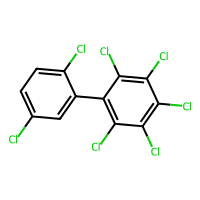

In [ ]:
def visualize_molecule(smiles):
    """
    Converts a SMILES string to an RDKit molecular image.
    If the SMILES is invalid, it returns an error message.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"Invalid SMILES: {smiles}")
        return None
    return Draw.MolToImage(mol, size=(200, 200))

if best_individual:
    best_smiles = best_individual[0]
    image = visualize_molecule(best_smiles)
    if image:
        display(image)
    else:
        print("Could not generate a valid molecule for visualization.")


# **Step 7: Track Optimization Progress**

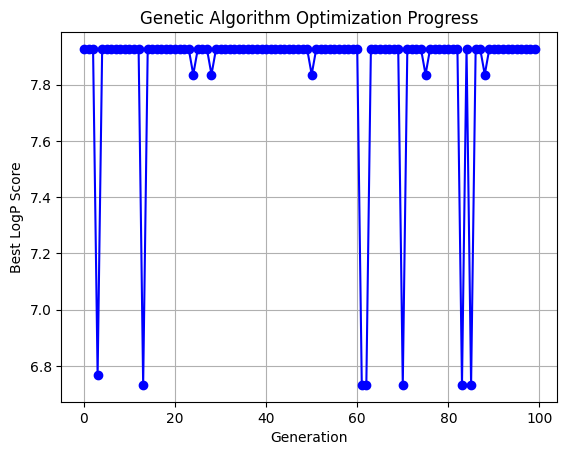

In [ ]:
# Ensure only valid fitness scores are plotted
fitness_scores = []
for ind in population:
    if isinstance(ind, list) and len(ind) > 0:
        smiles = ind[0]  # Extract SMILES
        if Chem.MolFromSmiles(smiles):  # Validate molecule
            fitness_scores.append(ind.fitness.values[0])

if fitness_scores:
    plt.plot(range(len(fitness_scores)), fitness_scores, marker='o', linestyle='-', color='b')
    plt.xlabel("Generation")
    plt.ylabel("Best LogP Score")
    plt.title("Genetic Algorithm Optimization Progress")
    plt.grid()
    plt.show()
else:
    print("No valid fitness scores to plot.")
